# Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Python Package Installation

In [1]:
! pip install subword-nmt

### Utils

In [1]:
%%writefile utils.py

def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text


def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()


Overwriting utils.py


### Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from transformers import BartTokenizer, BartForConditionalGeneration

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tqdm
import pandas as pd
import collections
import utils
import imp
import time
import math


### Dataset Preparation

In [3]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File 'data.txt' already there; not retrieving.



In [4]:
data_df = pd.read_csv(path_do_data, sep='\t', names=['trg', 'src'])
data_tuples = list(data_df.to_records(index=False))
data_tuples = [(x[1], x[0]) for x in data_tuples]

data_df

,trg,src
0,"Cordelia Hotel is situated in Tbilisi, a 3-min...","Отель Cordelia расположен в Тбилиси, в 3 минут..."
1,At Tupirmarka Lodge you will find a 24-hour fr...,В числе удобств лоджа Tupirmarka круглосуточна...
2,"Featuring free WiFi in all areas, Naigao Xiaow...",Апартаменты Naigao Xiaowo расположены в городе...
3,Each has a TV and a private bathroom with shower.,В вашем распоряжении также телевизор и собстве...
4,Your room comes with air conditioning and sate...,Номер оснащен кондиционером и спутниковым теле...
...,...,...
49995,The spacious air-conditioned rooms open out to...,Просторные номера с кондиционером выходят на с...
49996,Minsk Ring road is a 5-minute drive from the p...,Минская кольцевая автомобильная дорога проходи...
49997,There is a private bathroom with a shower.,В собственной ванной комнате установлен душ.
49998,It is a 15-minute drive from Malacca Town Cent...,За 15 минут вы доедете до центра города Малакк...


In [5]:
total_data = to_map_style_dataset(data_tuples)

train_len = int(len(total_data) * 0.8)
valid_len = int(len(total_data) * 0.15)
test_len = len(total_data) - train_len - valid_len

train_data, valid_data, test_data = random_split(total_data, [train_len, valid_len, test_len], generator=torch.Generator().manual_seed(42))

In [6]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 40000
Number of validation examples: 7500
Number of testing examples: 2500


### Setting up the device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

# Example Approach: Basic RNN

## Data Preparation

In [9]:
tokenizer_W = WordPunctTokenizer()

def tokenize(text):
    return tokenizer_W.tokenize(text.lower())

def yield_tokens(data_iter, tokenizer, language):
    language_index = {'src': 1, 'trg': 0}[language]
    
    for item in data_iter:
        yield tokenizer(item[language_index])
        
specials = ['<unk>', '<pad>', '<sos>', '<eos>']
init_token = '<sos>'
eos_token = '<eos>'

In [10]:
counter_src = collections.Counter()
counter_trg = collections.Counter()

for src, trg in train_data:
    counter_src.update(tokenize(src))
    counter_trg.update(tokenize(trg))

def apply_min_freq(counter, min_freq):
    return {word: freq for word, freq in counter.items() if freq >= min_freq}

filtered_vocab_src = apply_min_freq(counter_src, 3)
filtered_vocab_trg = apply_min_freq(counter_trg, 3)

vocab_src = build_vocab_from_iterator([filtered_vocab_src], specials=specials)
vocab_trg = build_vocab_from_iterator([filtered_vocab_trg], specials=specials)

vocab_src.set_default_index(vocab_src['<unk>'])
vocab_trg.set_default_index(vocab_trg['<unk>'])

itos_src = vocab_src.get_itos()  
itos_trg = vocab_trg.get_itos()

vocab_src.itos = itos_src
vocab_trg.itos = itos_trg

def collate_batch(batch):
    batch_size = len(batch)

    max_src_len = max(len(tokenize(src)) for src, trg in batch) + 2  # +2 for <sos> and <eos>
    max_trg_len = max(len(tokenize(trg)) for src, trg in batch) + 2  # +2 for <sos> and <eos>

    src_batch = torch.full((batch_size, max_src_len), vocab_src['<pad>'], dtype=torch.long)
    trg_batch = torch.full((batch_size, max_trg_len), vocab_trg['<pad>'], dtype=torch.long)

    for i, (src, trg) in enumerate(batch):
        src_tokens = [vocab_src['<sos>']] + [vocab_src[token] for token in tokenize(src)] + [vocab_src['<eos>']]
        trg_tokens = [vocab_trg['<sos>']] + [vocab_trg[token] for token in tokenize(trg)] + [vocab_trg['<eos>']]

        src_batch[i, :len(src_tokens)] = torch.tensor(src_tokens, dtype=torch.long)
        trg_batch[i, :len(trg_tokens)] = torch.tensor(trg_tokens, dtype=torch.long)

    src_batch = src_batch.transpose(0, 1)
    trg_batch = trg_batch.transpose(0, 1)

    return src_batch.to(device), trg_batch.to(device)

In [11]:
print(f"Unique tokens in source vocabulary: {len(vocab_src)}")
print(f"Unique tokens in target vocabulary: {len(vocab_trg)}")

Unique tokens in source vocabulary: 9310

Unique tokens in target vocabulary: 6711


Here are tokens from original (RU) corpus:

In [12]:
print(vocab_src.itos[::1000])


['<unk>', 'дерева', 'downtown', 'кататься', 'центрами', 'шах', 'margarita', 'трибхуван', 'дагомыс', 'стереосистемой']


And from target (EN) corpus:

In [13]:
print(vocab_trg.itos[::1000])

['<unk>', 'palma', 'groves', 'biscuits', 'mayan', 'states', 'malagueta']


And here is example from train dataset:

In [14]:
print(tokenize(train_data[0][0]))
print(tokenize(train_data[0][1]))

['в', 'распоряжении', 'гостей', 'мини', '-', 'бар', ',', 'телевизор', 'и', 'ванная', 'комната', 'с', 'ванной', 'и', 'душем', '.']

['each', 'has', 'a', 'bathroom', 'with', 'a', 'bath', 'and', 'a', 'shower', ',', 'as', 'well', 'as', 'a', 'minibar', 'and', 'a', 'tv', '.']


Let's check the length distributions:

Length distribution in Train data


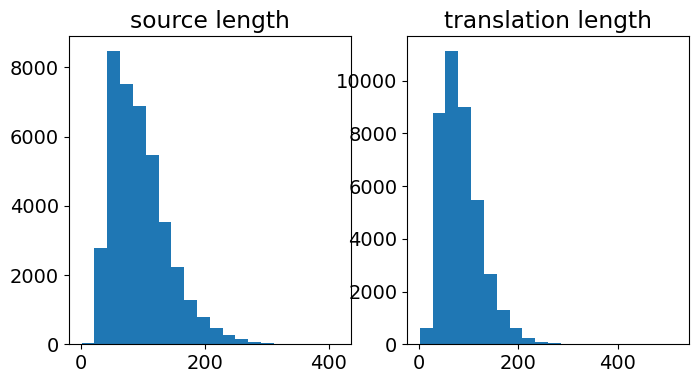

In [15]:
src_length = map(len, [x[0] for x in train_data])
trg_length = map(len, [x[1] for x in train_data])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


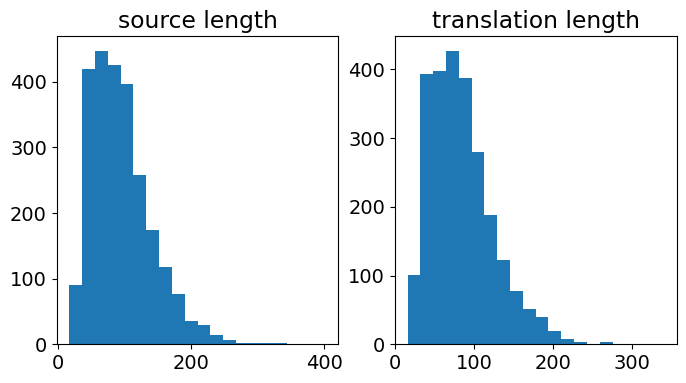

In [16]:
src_length = map(len, [x[0] for x in test_data])
trg_length = map(len, [x[1] for x in test_data])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

## Model Training
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

### Model Code

In [17]:
%%writefile my_network.py
import torch
import torch.nn as nn

import random


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim)

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):

        embedded = self.embedding(src)

        embedded = self.dropout(embedded)

        output, (hidden, cell) = self.rnn(embedded)

        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(num_embeddings=output_dim, embedding_dim=emb_dim)

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )

        self.out = nn.Linear(in_features=hid_dim, out_features=output_dim)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden, cell):

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))

        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert (
            encoder.hid_dim == decoder.hid_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):

        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)

        input = trg[0, :]

        for t in range(1, max_len):

            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = trg[t] if teacher_force else top1

        return outputs


Writing my_network.py


### Preparing Training

In [18]:
BATCH_SIZE = 128

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))


In [19]:
for x in train_loader:
    break
print(x)
print(x[0].shape, x[1].shape)

(tensor([[  2,   2,   2,  ...,   2,   2,   2],

        [252,   5,  34,  ...,   5,  67,  21],

        [253,  71,  13,  ..., 119, 207,  25],

        ...,

        [  1,   1,   1,  ...,   1,   1,   1],

        [  1,   1,   1,  ...,   1,   1,   1],

        [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0'), tensor([[   2,    2,    2,  ...,    2,    2,    2],

        [ 241,  425, 1869,  ...,   92,   28,   30],

        [ 759,   12,    0,  ...,  425,  215,   27],

        ...,

        [   1,    1,    1,  ...,    1,    1,    1],

        [   1,    1,    1,  ...,    1,    1,    1],

        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0'))

torch.Size([65, 128]) torch.Size([60, 128])


In [20]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [21]:
INPUT_DIM = len(vocab_src)
OUTPUT_DIM = len(vocab_trg)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9310, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6711, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6711, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,900,535 trainable parameters


In [24]:
PAD_IDX = vocab_trg['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [25]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in tqdm.tqdm(enumerate(iterator)):
        
        src = batch[0]
        trg = batch[1]
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].reshape(-1)
        # trg[1:].reshape(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0]
            trg = batch[1]

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].reshape(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

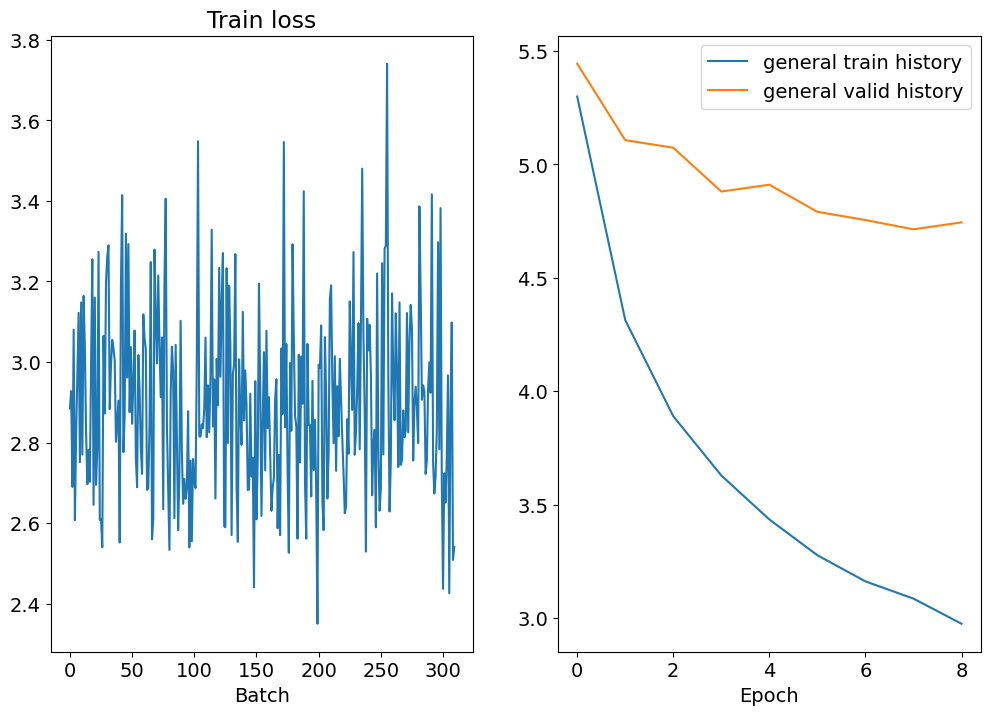

313it [01:39,  3.16it/s]


Epoch: 10 | Time: 1m 48s

	Train Loss: 2.897 | Train PPL:  18.118

	 Val. Loss: 4.759 |  Val. PPL: 116.605

CPU times: user 17min 7s, sys: 6min 27s, total: 23min 35s

Wall time: 18min 6s


In [29]:
%%time

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

## Evaluation

In [30]:
# load trained model

model.load_state_dict(torch.load('tut1-model.pt', map_location=device))

<All keys matched successfully>

In [31]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [32]:
batch = next(iter(test_loader))

In [33]:
for idx in [1,2]:
    src = batch[0][:, idx:idx+1]
    trg = batch[1][:, idx:idx+1]
    generate_translation(src, trg, model, vocab_trg)

Original: each room here will provide you with air conditioning .

Generated: all room here will provide you with air conditioning .



Original: take advantage of the large , free car park .

Generated: free parking is available on site .




In [34]:
#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [35]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_loader)):

        src = batch[0]
        trg = batch[1]

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, vocab_trg) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, vocab_trg) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

20it [00:02,  6.76it/s]


In [36]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

16.48372730807763

# Approach 1: Attention

## Data Preparation

In [38]:
tokenizer_W = WordPunctTokenizer()

def tokenize(text):
    return tokenizer_W.tokenize(text.lower())

def yield_tokens(data_iter, tokenizer, language):
    language_index = {'src': 1, 'trg': 0}[language]
    
    for item in data_iter:
        yield tokenizer(item[language_index])
        
specials = ['<unk>', '<pad>', '<sos>', '<eos>']
init_token = '<sos>'
eos_token = '<eos>'

counter_src = collections.Counter()
counter_trg = collections.Counter()

for src, trg in train_data:
    counter_src.update(tokenize(src))
    counter_trg.update(tokenize(trg))

def apply_min_freq(counter, min_freq):
    return {word: freq for word, freq in counter.items() if freq >= min_freq}

filtered_vocab_src = apply_min_freq(counter_src, 3)
filtered_vocab_trg = apply_min_freq(counter_trg, 3)

vocab_src = build_vocab_from_iterator([filtered_vocab_src], specials=specials)
vocab_trg = build_vocab_from_iterator([filtered_vocab_trg], specials=specials)

vocab_src.set_default_index(vocab_src['<unk>'])
vocab_trg.set_default_index(vocab_trg['<unk>'])

itos_src = vocab_src.get_itos()  
itos_trg = vocab_trg.get_itos()

vocab_src.itos = itos_src
vocab_trg.itos = itos_trg

def collate_batch(batch):
    batch_size = len(batch)

    max_src_len = max(len(tokenize(src)) for src, trg in batch) + 2  # +2 for <sos> and <eos>
    max_trg_len = max(len(tokenize(trg)) for src, trg in batch) + 2  # +2 for <sos> and <eos>

    src_batch = torch.full((batch_size, max_src_len), vocab_src['<pad>'], dtype=torch.long)
    trg_batch = torch.full((batch_size, max_trg_len), vocab_trg['<pad>'], dtype=torch.long)

    for i, (src, trg) in enumerate(batch):
        src_tokens = [vocab_src['<sos>']] + [vocab_src[token] for token in tokenize(src)] + [vocab_src['<eos>']]
        trg_tokens = [vocab_trg['<sos>']] + [vocab_trg[token] for token in tokenize(trg)] + [vocab_trg['<eos>']]

        src_batch[i, :len(src_tokens)] = torch.tensor(src_tokens, dtype=torch.long)
        trg_batch[i, :len(trg_tokens)] = torch.tensor(trg_tokens, dtype=torch.long)

    src_batch = src_batch.transpose(0, 1)
    trg_batch = trg_batch.transpose(0, 1)

    return src_batch.to(device), trg_batch.to(device)

## Model Training

### Model Code

In [39]:
%%writefile attention.py
import torch
import torch.nn as nn
import torch.nn.functional as F

import random


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )

        return outputs, hidden


class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(
        self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention
    ):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        a = self.attention(hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted = torch.bmm(a, encoder_outputs)

        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim=2)

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        return prediction, hidden.squeeze(0), a


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        input = trg[0, :]

        for t in range(1, trg_len):

            output, hidden, a = self.decoder(input, hidden, encoder_outputs)

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1

        return outputs



Writing attention.py


### Preparing Training

In [40]:
BATCH_SIZE = 128

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))

import attention
Encoder = attention.Encoder
Attention = attention.Attention
Decoder = attention.Decoder
Seq2Seq = attention.Seq2Seq

INPUT_DIM = len(vocab_src)
OUTPUT_DIM = len(vocab_trg)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(HID_DIM, HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, DEC_DROPOUT, attn)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

PAD_IDX = vocab_trg['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)


The model has 22,567,479 trainable parameters


In [41]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in tqdm.tqdm(enumerate(iterator)):
        
        src = batch[0]
        trg = batch[1]
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].reshape(-1)
        # trg[1:].reshape(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0]
            trg = batch[1]

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].reshape(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

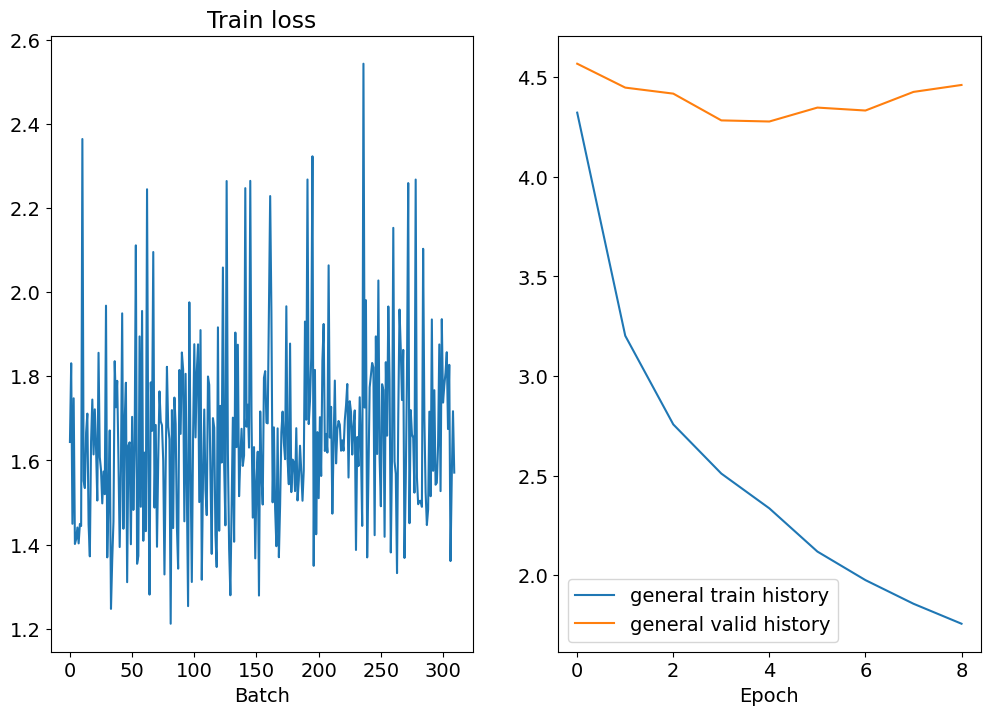

313it [03:08,  1.66it/s]


Epoch: 10 | Time: 3m 23s

	Train Loss: 1.663 | Train PPL:   5.273

	 Val. Loss: 4.509 |  Val. PPL:  90.809

CPU times: user 30min 38s, sys: 8min 34s, total: 39min 13s

Wall time: 33min 43s


In [43]:
%%time

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attention-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

## Evaluation

In [45]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

# load trained model

model.load_state_dict(torch.load('attention-model.pt', map_location=device))

original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_loader)):

        src = batch[0]
        trg = batch[1]

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, vocab_trg) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, vocab_trg) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

20it [00:04,  4.11it/s]


In [46]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

29.688592837088233

## Summary

This is the first approach to improve the translation quality. The model is trained with attention mechanism on a sequence-to-sequence model. The model is trained for 10 epochs and the BLEU score is calculated on the test dataset. The BLEU score is 29. The model has 22,567,479 trainable. This model was train on GPU P100 on Kaggle Platform.

# Approach 2: Transformer

## Data Preparation

In [8]:
! python -m spacy download ru_core_news_sm
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 71.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 73.1 MB/s eta 0:00:00:00:010:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [21]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List

SRC_LANGUAGE = 'ru'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='ru_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_data, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

## Creating the model

In [22]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [23]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Training the model

In [24]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 64,368,282 trainable parameters


In [25]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [26]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer, train_history=None, valid_history=None):
    model.train()
    losses = 0
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    history = []

    i = 0

    for src, tgt in tqdm.tqdm(train_dataloader, total=len(train_dataloader)):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        i += 1

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in tqdm.tqdm(val_dataloader, total=len(val_dataloader)):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

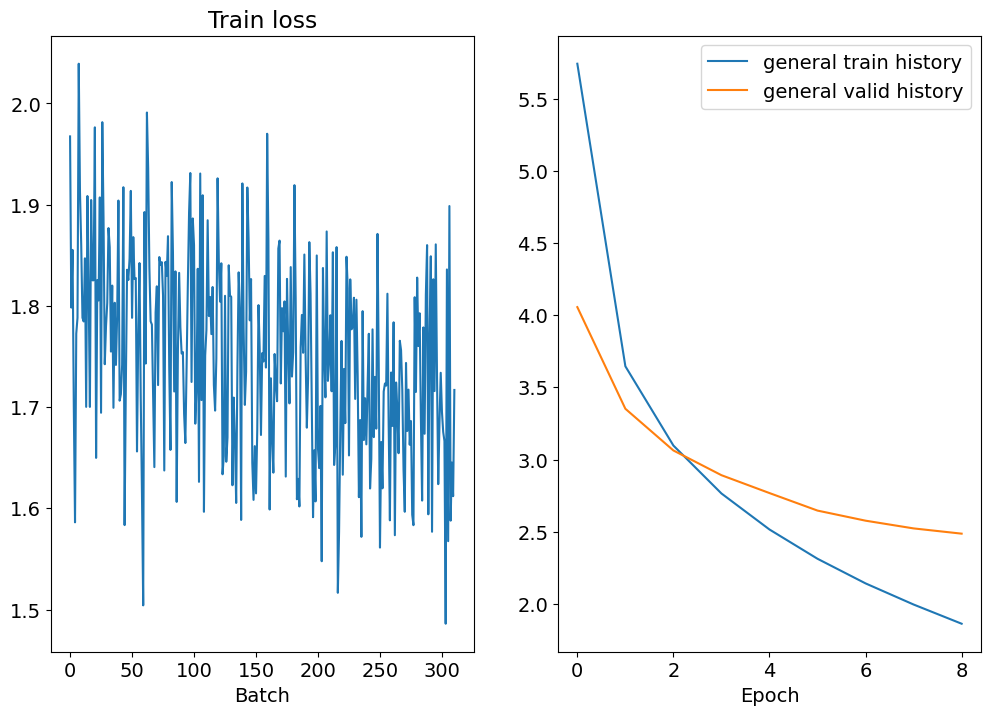

100%|██████████| 59/59 [00:05<00:00, 10.55it/s]


Epoch: 10, Train loss: 1.750, Val loss: 2.441, Epoch time = 96.975s
CPU times: user 17min 57s, sys: 56.2 s, total: 18min 53s
Wall time: 17min 27s


In [27]:
%%time

from timeit import default_timer as timer
NUM_EPOCHS = 10

best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, train_history, valid_history)
    end_time = timer()
    val_loss = evaluate(transformer)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(transformer.state_dict(), 'transformer-model.pt')

        
    train_history.append(train_loss)
    valid_history.append(val_loss)


    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

## Evaluation

In [39]:
transformer.load_state_dict(torch.load('transformer-model.pt', map_location=device))

<All keys matched successfully>

In [40]:
original_text = []
generated_text = []

for src, tgt in tqdm.tqdm(test_data):

    original_text.append(tgt)
    generated_text.append(translate(transformer, src))

100%|██████████| 2500/2500 [03:17<00:00, 12.66it/s]


In [41]:
print(original_text[:5])
print(generated_text[:5])

['All apartments have a DVD player and satellite TV, a kitchen with a microwave, and a washing machine and a tumble dryer.', 'They are fitted with blackout curtains, free drinking water and free toiletries.', 'A small refrigerator, coffee-making facilities and a work desk are included.', 'Only 250 metres away, Paral•lel Metro Station offers direct links to Plaça Catalunya and Montjuïc Hill.', 'The apartment will provide you with a satellite TV and air conditioning.There is a full a kitchen with a dishwasher and a refrigerator.']
[' Each has a TV with satellite channels and a DVD player . A washing machine and a tumble dryer are also included . ', ' Free toiletries and a free toiletries are provided . ', ' A small refrigerator , coffee maker and work desk are also provided . ', ' The metro station , with direct links to Rome , which are just 250 metres away from Plaza Catalunya and the town of Plaza . ', ' The air - conditioned apartment is equipped with a fully equipped kitchen with a 

In [42]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

52.54415758450054

## Summary

This is the second approach to improve the translation quality. The model is trained with transformer model, using tokenizer from Spacy for english and russian languages. The model is trained for 10 epochs. The BLEU score is 52. The model has 64,368,282 trainable parameters having around four times more amount parameters than the basic RNN model. This model was train on GPU P100 on Kaggle Platform.

# Approach 3: fine-tunning BART

## Data Preparation

In [48]:
bart_name = "facebook/bart-base"
bart_tokenizer = BartTokenizer.from_pretrained(bart_name)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [49]:
def collate_batch(batch):
    src_texts = [item[0] for item in batch]  
    trg_texts = [item[1] for item in batch]

    tokenizer = bart_tokenizer(
        text=src_texts,
        text_target=trg_texts,
        padding="longest",
        truncation=True,
        return_tensors="pt",
    )

    labels = tokenizer["labels"]
    labels[labels == bart_tokenizer.pad_token_id] = -100

    return {
        "input_ids": tokenizer["input_ids"],
        "attention_mask": tokenizer["attention_mask"],
        "labels": labels,
    }

BATCH_SIZE = 16

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))

## Model Training

In [50]:
from tqdm import tqdm 

def train_epoch(model, data_loader, optimizer, device, train_history=None, valid_history=None):
    model.train()
    total_loss = 0

    history = []

    i = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                        labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
            
        i += 1

    print(f"Average training loss: {total_loss / len(data_loader)}")
    return total_loss / len(data_loader)

def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                            labels=labels)

            loss = outputs.loss
            total_loss += loss.item()

    print(f"Average validation loss: {total_loss / len(data_loader)}")
    return total_loss / len(data_loader)


In [51]:
bart = BartForConditionalGeneration.from_pretrained(bart_name).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(bart):,} trainable parameters')

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

The model has 139,420,416 trainable parameters


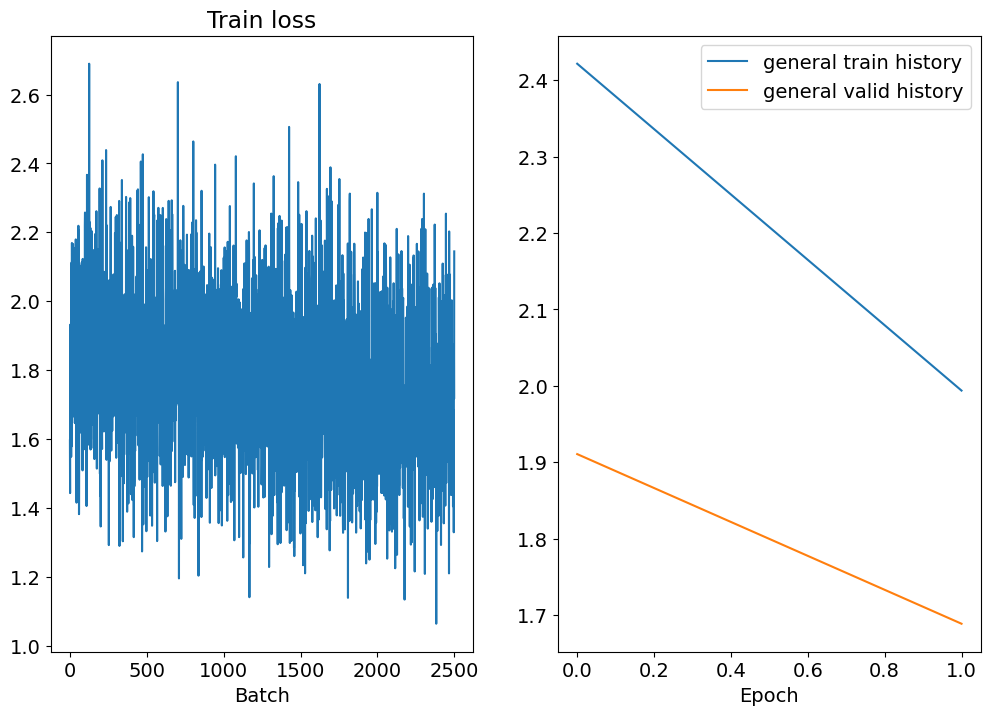

Training: 100%|██████████| 2500/2500 [14:12<00:00,  2.93it/s]


Average training loss: 1.7743002724647523


Evaluating: 100%|██████████| 469/469 [00:44<00:00, 10.58it/s]


Average validation loss: 1.5216944013068925

CPU times: user 46min 9s, sys: 2min 6s, total: 48min 15s

Wall time: 44min 50s


In [53]:
%%time

num_epochs = 3

optimizer = optim.AdamW(bart.parameters(), lr=5e-6)

best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss = train_epoch(bart, train_loader, optimizer, device, train_history, valid_history)
    valid_loss = eval_model(bart, valid_loader, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bart.state_dict(), 'bart-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

## Evaluation

In [54]:
bart.load_state_dict(torch.load('bart-model.pt', map_location=device))

<All keys matched successfully>

In [55]:
original_text = []
generated_text = []

def translate(batch):

    src_ids = batch["input_ids"].to(device)
    src_mask = batch["attention_mask"].to(device)
    labels = batch["labels"]

    outputs = bart.generate(
        src_ids,
        attention_mask=src_mask,
        num_beams=5,
        max_length=100,
        early_stopping=True,
    )

    src_texts = [
        bart_tokenizer.decode(s, skip_special_tokens=True) for s in src_ids
    ]

    translated_texts = [
        bart_tokenizer.decode(o, skip_special_tokens=True) for o in outputs
    ]

    trg_texts = [
        bart_tokenizer.decode(t[t != -100], skip_special_tokens=True)
        for t in labels
    ]

    return src_texts, trg_texts, translated_texts


bart.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):

        src_texts, trg_texts, translated_texts = translate(batch)

        original_text.extend(trg_texts)
        generated_text.extend(translated_texts)

157it [03:42,  1.42s/it]


In [56]:
print(original_text[:5])
print(generated_text[:5])

['It offers well-equipped rooms and a daily breakfast buffet.', 'Each room here will provide you with air conditioning.', 'Take advantage of the large, free car park.', 'Air conditioned rooms are provided with a flat-screen TV, seating area and minibar.', 'Complejo Alcaidia De Magina is located in the charming Andalusian hillside town of Cambil.']

['It offers spacious rooms and a daily buffet breakfast.', 'Each room here will provide you with air conditioning.', 'Free parking is available on site.', 'The air-conditioned rooms feature a flat-screen TV, seating area and minibar.', 'Hotel Complejo Alcaidia De Magina is located in a quiet area in the centre of Campeche.']


In [57]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

53.165626853597104

## Summary

This is the third approach to improve the translation quality. This approach uses fine-tunning BART model and its own tokenizer. The model was fine-tunned for 3 epochs. The BLEU score is 53. The model has 139,420,416 trainable parameters having around 10 times more amount parameters than the basic RNN model. This model was train on GPU P100 on Kaggle Platform.

# Model Comparison

In [18]:
import pandas as pd

data = {
    "Model": ["RNN", "Attention", "Transformer", "BART"],
    "Translation Quality (BLEU score)": [16, 29, 52, 53],
    "Complexity (trainable parameters)": ["14,900,535", "22,567,479", "64,368,282", "139,420,416"],
    "Training Time": ["18 min", "33 min", "17 min", "44 min"],
    "Evaluation Time": ["2 sec", "4 sec", "3 min", "3 min"]
}

df = pd.DataFrame(data)

df.set_index("Model", inplace=True)

print("Comparison of Models (Trained on GPU P100)")
display(df)


Comparison of Models (Trained on GPU P100)


,Translation Quality (BLEU score),Complexity (trainable parameters),Training Time,Evaluation Time
Model,,,,
RNN,16,"14,900,535",18 min,2 sec
Attention,29,"22,567,479",33 min,4 sec
Transformer,52,"64,368,282",17 min,3 min
BART,53,"139,420,416",44 min,3 min
